# Sarcasm classification with pretrain embeddings

Natural language processing notebook to classify news headlines as sarcastic or not. This time using pretrained embeddings taken from Glove.

Dataset:

*   from kaggle - https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home
*   News headlines from The Onion = sarcastic
*   News headlines from Huffington Post = not sarcastic

Notebook summary:
*   News headlines are sentences
*   Convert to word tokens
*   Convert to vocab of integers
*   Training matrix is generated by padding the sentences to the same length
*   Train model to
    *   convert vocab integers to vector embeddings
    *   average the embedding vectors per sentence
    *   then to single class to suggest is sarcastic
*   Model trained to minimise binary cross entropy loss
*   Plots ROC/PR curves to check overfitting

References:

*   https://www.youtube.com/watch?v=Y_hzMnRXjhI
*   https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html
*   https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
*   https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222/17

First we load the data into a torch dataset which requires the `__len__` and `__get_item__` methods.

In [70]:
import torch
import json
from pathlib import Path
import random


class SarcasmData(torch.utils.data.dataset.Dataset):
    """Load sentiment data. Takes only headline and sentiment from data."""

    def __init__(
        self,
        filepath: Path,
    ):
        self.sentences = []
        self.labels = []

        with open(filepath, "r") as f:
            for line in f:
                json_contents = json.loads(line)
                self.sentences.append(json_contents["headline"])
                self.labels.append(json_contents["is_sarcastic"])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.sentences[index], self.labels[index]


# assumes data is already downloaded from kaggle to the following path
full_dataset = SarcasmData(
    filepath=Path("data/Sarcasm_Headlines_Dataset.json")
)

# split train and test sets
num_train = int(len(full_dataset) * 0.8)
train_dataset, test_dataset = torch.utils.data.dataset.random_split(
    full_dataset,
    [num_train, len(full_dataset) - num_train],
    generator=torch.Generator().manual_seed(42),
)

# get a random row of the dataset
x, y = train_dataset[random.randint(0, len(train_dataset))]
x, y


("trump's lawyer got restraining order against stormy daniels to keep her quiet",
 0)

Convert the headline sentences into word tokens

In [71]:
# normalise string to tokens
# build tokenizer to take sentence and split to List[str]
# build vocab to generate List[int]

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = iter(train_dataset)


def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], min_freq=3
)
vocab.set_default_index(vocab["<unk>"])

vocab(["here", "is", "an", "example"])
vocab(tokenizer(x))

print(f"Vocab length: {len(vocab)}")


Vocab length: 9030


Build pipelines to transform a data tuple into appropriate training vectors and labels.

In [72]:
import numpy as np

max_seq_length = 100
cost_fcn = "bin"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def text_pipeline(text):
    """Take a text sentence, convert to vocab integers and pad with 0s to the same length."""

    text_tokens = vocab(tokenizer(text[:max_seq_length]))
    padded_tokens = np.zeros((1, max_seq_length), dtype=np.int64)
    padded_tokens[0, 0 : len(text_tokens)] = text_tokens
    return torch.from_numpy(padded_tokens)


def label_pipeline(label):
    return torch.tensor([label])


def collate_batch(batch):
    """Transform batch from dataset for the text/label pipelines.
    Creates numpy array of text tokens and labels.
    Use only the first N word token"""

    token_list = []
    label_list = []
    for _text, _label in batch:
        token_list.append(text_pipeline(_text))
        label_list.append(label_pipeline(_label))

    if cost_fcn == "bin":
        # class probs
        labels = torch.cat(label_list).type(torch.DoubleTensor)[:, None]
    else:
        # class indices
        labels = torch.cat(label_list).type(torch.int64)
    text_tokens = torch.cat(token_list, dim=0)

    return text_tokens.to(device), labels.to(device)


Create dataloaders to process the data via the collate function. Dataloaders are required to feed the data into Pytorch lightning for training.
We further split the training dataset to a train and validation set so we can apply early stopping.

In [73]:
BATCH_SIZE = 64

num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = torch.utils.data.dataset.random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train],
    generator=torch.Generator().manual_seed(42),
)

train_dataloader = torch.utils.data.DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = torch.utils.data.DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

text_tokens, labels = next(iter(train_dataloader))

print(f"text token shape: {text_tokens.shape}")
print(f"labels shape: {labels.shape}")


text token shape: torch.Size([64, 100])
labels shape: torch.Size([64, 1])


## Load pretrained embeddings

Using the smallest Glove vectors.

We need to find entries for words in our vocab.
We load the glove embeddings and then filter for our vocab list.

In [68]:
matched_words = {}
word_list = []
word_token_list = []

with open(Path("data/glove.6B.50d.txt"), "r") as f:
    for line in f:
        line = f.readline().split()

        if len(line)==0:
            continue
        # check if in vocab
        vocab_index = vocab.lookup_indices(tokenizer(line[0]))

        if len(vocab_index)==0:
            continue
        vocab_index = vocab_index[0]
        if vocab_index != 0:
            matched_words[vocab_index] = np.array(line[1:])
            word_list.append(line[0])
            word_token_list.append(tokenizer(line[0])[0])

print(f"No. matched words: {len(matched_words)}")

No. matched words: 4642


The tokenizer gives slightly different matches from the glove list. This currently takes the last vector for the same tokens.

In [83]:
print(word_list[:10])
print(word_token_list[:10])

[',', 'of', 'and', 'a', "'s", '-', 'on', 'was', 'with', 'as']
[',', 'of', 'and', 'a', "'", '-', 'on', 'was', 'with', 'as']


Create weights matrix

In [88]:

from numpy.random import default_rng
embed_size = 50
vocab_size = len(vocab)

# non matched words get random assignment
glove_weights_matrix = np.random.default_rng().normal(size=(vocab_size, embed_size))

# replace matched words in the weights matrix
for key, val in matched_words.items():
    glove_weights_matrix[key] = val

glove_weights_matrix.shape

(9030, 50)

Create embedding layer

In [89]:
glove_embeddings = torch.nn.EmbeddingBag(
    num_embeddings=vocab_size, embedding_dim=embed_size, mode="mean"
)

glove_embeddings.weight.data.copy_(torch.from_numpy(glove_weights_matrix))


if 0:
    # prevent tuning embeddings, not useful when we have non-matched words (random weights)
    glove_embeddings.weight.requires_grad = False

In [91]:
glove_embeddings.embedding_dim

50

Create the model definition.
We use an `EmbeddingBag` to take the padded sentences and convert to embedding vectors.
We then take the mean of the vectors to give a single average vector, of dimension equal to the embedding size.

The loss function is set to binary cross entropy as we have a single binary output class to predict. This requires the target labels to be of type `float`. This is different to `CrossEntropyLoss` where the labels are the class index and are set as integers. They also require the labels to be a single vector ([N]), rather than a vector per training row ([N x 1]).
This is setup in the `collate_batch` function.

In [92]:
import pytorch_lightning as pl


class TextClassificationModelPL(pl.LightningModule):
    def __init__(
        self,
        vocab_size,
        embed_size,
        num_class,
        learning_rate=1e-3,
        embedding_layer = None
    ):
        super().__init__()
        if embedding_layer is None:
            self.embedding = torch.nn.EmbeddingBag(
                num_embeddings=vocab_size, embedding_dim=embed_size, mode="mean"
            )
        else:
            self.embedding = embedding_layer

        self.fc1 = torch.nn.Linear(self.embedding.embedding_dim, 24)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(24, num_class)

        self.train_log_error = []
        self.val_log_error = []
        self.learning_rate = learning_rate
        self.loss = torch.nn.BCEWithLogitsLoss()  # requires one output column
        # self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, text_tokens):
        embedded = self.embedding(text_tokens)
        fc1ed = self.fc1(embedded)
        relued = self.relu(fc1ed)
        return self.fc2(relued)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        (text_tokens, labels) = batch

        output = self.forward(text_tokens)
        loss = self.loss(output, labels)

        self.train_log_error.append(loss.detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        (text_tokens, labels) = batch

        output = self.forward(text_tokens)
        loss = self.loss(output, labels)

        self.log("val_loss", loss, on_epoch=True)
        self.val_log_error.append(loss.detach().numpy())
        return loss


In [94]:
from torchinfo import summary

num_class = 1 if cost_fcn == "bin" else 2
model = TextClassificationModelPL(
    vocab_size=vocab_size, embed_size=embed_size, num_class=num_class, embedding_layer=glove_embeddings
).to(device)

# setup dummy input data to get dimensions of layer outputs
tokens = [[7, 43, 67, 7, 43, 68], [1, 2, 3, 4, 5, 6]]
summary(model, input_data=(torch.tensor(tokens)))


Layer (type:depth-idx)                   Output Shape              Param #
TextClassificationModelPL                --                        --
├─EmbeddingBag: 1-1                      [2, 50]                   451,500
├─Linear: 1-2                            [2, 24]                   1,224
├─ReLU: 1-3                              [2, 24]                   --
├─Linear: 1-4                            [2, 1]                    25
├─BCEWithLogitsLoss: 1-5                 --                        --
Total params: 452,749
Trainable params: 452,749
Non-trainable params: 0
Total mult-adds (M): 0.91
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.81
Estimated Total Size (MB): 1.81

In [95]:
# train
import matplotlib.pyplot as plt
import numpy as np

# fit network
trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=3)
    ],
)
trainer.fit(model, train_dataloader, valid_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type              | Params
------------------------------------------------
0 | embedding | EmbeddingBag      | 451 K 
1 | fc1       | Linear            | 1.2 K 
2 | relu      | ReLU              | 0     
3 | fc2       | Linear            | 25    
4 | loss      | BCEWithLogitsLoss | 0     
------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.811     Total estimated model params size (MB)


/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the numbe

Epoch 15: 100%|██████████| 335/335 [00:04<00:00, 79.60it/s, loss=0.209, v_num=24]


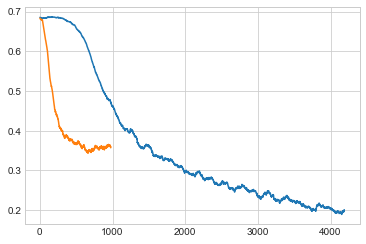

In [96]:
# plot training loss
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")


def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


plt.plot(moving_average(np.array(model.train_log_error)))
plt.plot(moving_average(np.array(model.val_log_error)))


## Validating results

Checking some individual predictions from the train/validiation/test datasets.

In [97]:
import random


def predict_text(text: str):
    with torch.no_grad():
        log_probit = model(text_pipeline(text))
    if cost_fcn == "bin":
        proba = torch.nn.Sigmoid()(log_probit).item()
    else:
        proba = torch.nn.Softmax(dim=1)(log_probit)[0][1].item()

    print(text)
    print("p(is sarcastic)= ", proba)


def check_prediction(data_tuple):
    predict_text(data_tuple[0])
    print("is sarcastic: ", data_tuple[1])
    print("--------------")

random.seed(0)
check_prediction(split_train_[random.randint(0, len(split_train_))])
check_prediction(split_valid_[random.randint(0, len(split_valid_))])
check_prediction(test_dataset[random.randint(0, len(test_dataset))])


nemesis lands alumni magazine cover
p(is sarcastic)=  0.9552599787712097
is sarcastic:  1
--------------
john legend gushing about chrissy teigen and baby luna is just the cutest
p(is sarcastic)=  0.0015486386837437749
is sarcastic:  0
--------------
meatless monday: the seed of something great -- seed food and wine festival
p(is sarcastic)=  0.004775650799274445
is sarcastic:  0
--------------


In [98]:
def predict_whole_dataloader(dataloader, prob_output: bool = True):
    dataloader = torch.utils.data.DataLoader(
        dataset=dataloader.dataset,
        batch_size=len(dataloader.dataset),
        collate_fn=collate_batch,
    )
    (text_tokens, labels) = next(iter(dataloader))

    with torch.no_grad():
        output = model.forward(text_tokens)

    if cost_fcn == "bin":
        output = torch.nn.Sigmoid()(output)
    else:
        output = torch.nn.Softmax(dim=1)(output)

    if not prob_output:
        if cost_fcn == "bin":
            # assume 0.5 prob threshold
            output = output > 0.5
        else:
            output = output.argmax(1)

    return output, labels


dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
    "test": test_dataloader,
}


Model loss and accuracy on the whole datasets shows a reasonable accuracy of >80% and we are not overfitting significantly.

In [99]:
# test performance
def evaluate(dataloader):
    output, labels = predict_whole_dataloader(dataloader, prob_output=True)
    loss = model.loss(output, labels)

    output, labels = predict_whole_dataloader(dataloader, prob_output=False)
    accuracy = ((output == labels).sum() / len(labels)).item()
    print(f"model loss, accuracy = {loss:8.3f}, {accuracy:8.3f}")

    return loss, accuracy


for name, dataloader in dataloaders.items():
    print(f"Checking the results of {name} dataset.")
    evaluate(dataloader)


Checking the results of train dataset.
model loss, accuracy =    0.582,    0.932
Checking the results of valid dataset.
model loss, accuracy =    0.614,    0.848
Checking the results of test dataset.
model loss, accuracy =    0.618,    0.850


### Other diagnostics

The precision-recall and ROC curves are plotted by varying the threshold for a positive classification. They give a more robust representation of performance in the case of unbalanced classes.
They show as we increase the threshold for a positive class label from 0 -> 1, how does this trade off true positives vs false positives, e.g. detecting nothing as sarcastic through to detecting everything as sarcastic.

ROC - a random classifier has a straight line on the diagonal. Better performance is seen for classifiers with a larger area under the curve (AUC).

Text(0.5, 1.0, 'ROC curve')

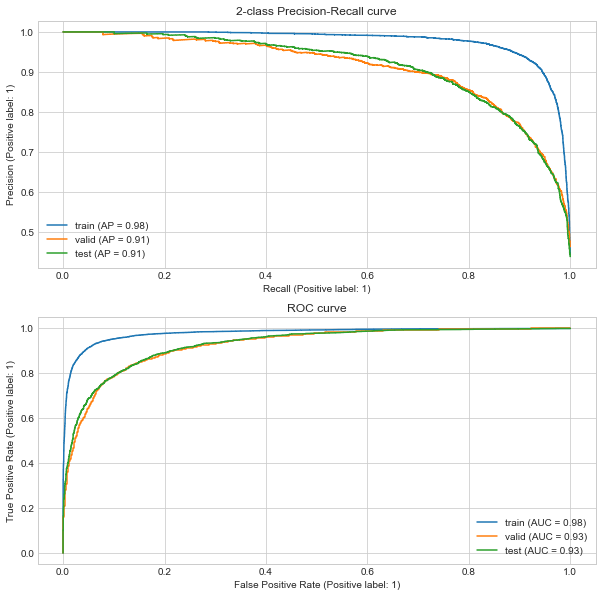

In [100]:
import sklearn.metrics

fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
for name, dataloader in dataloaders.items():
    proba, labels = predict_whole_dataloader(dataloader)
    display = sklearn.metrics.PrecisionRecallDisplay.from_predictions(
        y_true=labels, y_pred=proba, name=name, ax=ax[0]
    )
    display = sklearn.metrics.RocCurveDisplay.from_predictions(
        y_true=labels, y_pred=proba, name=name, ax=ax[1]
    )
ax[0].set_title("2-class Precision-Recall curve")
ax[1].set_title("ROC curve")


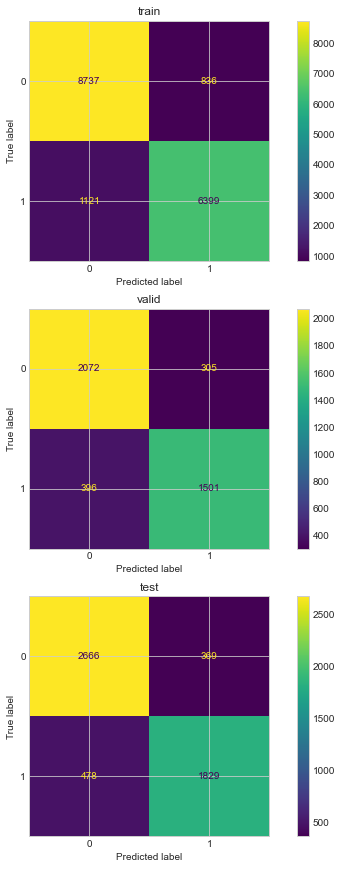

In [12]:
# confusion matrix
fig, ax = plt.subplots(figsize=(10, 5 * len(dataloaders)), nrows=len(dataloaders))
for idx, (name, dataloader) in enumerate(dataloaders.items()):
    output, labels = predict_whole_dataloader(dataloader, prob_output=False)

    cm = sklearn.metrics.confusion_matrix(y_true=labels, y_pred=output)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(cm).plot(ax=ax[idx])
    ax[idx].set_title(name)
